In [6]:
import pandas as pd 
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic

import geopandas as gpd
from cartoframes.viz import *
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [7]:
df = pd.read_csv('../../data/nyc/raw/NYC_train.csv')
df

,user_id,POI_id,POI_catid,POI_catid_code,POI_catname,latitude,longitude,timezone,UTC_time,local_time,day_of_week,norm_in_day_time,trajectory_id,norm_day_shift,norm_relative_time
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,75,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-03 18:00:09+00:00,2012-04-03 14:00:09+00:00,1,0.583333,470_1,0,0.583333
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,252,Bridge,40.606800,-74.044170,-240,2012-04-03 18:00:25+00:00,2012-04-03 14:00:25+00:00,1,0.583333,979_1,0,0.583333
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,6,Home (private),40.716162,-73.883070,-240,2012-04-03 18:02:24+00:00,2012-04-03 14:02:24+00:00,1,0.583333,69_1,0,0.583333
3,428,4ce1863bc4f6a35d8bd2db6c,4bf58dd8d48988d103941735,6,Home (private),40.619151,-74.035888,-240,2012-04-03 18:06:18+00:00,2012-04-03 14:06:18+00:00,1,0.583333,428_1,0,0.583333
4,116,4c0ab56f7e3fc9288c1df482,4f04afc02fb6e1c99f3db0bc,362,Mobile Phone Shop,40.741191,-73.989663,-240,2012-04-03 18:09:29+00:00,2012-04-03 14:09:29+00:00,1,0.583333,116_1,0,0.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83223,529,50170a53e4b07ac9f310b944,4bf58dd8d48988d1e0931735,253,Coffee Shop,40.709272,-74.005450,-300,2012-11-09 20:45:40+00:00,2012-11-09 15:45:40+00:00,4,0.645833,529_56,0,0.645833
83224,354,4a9fc4fbf964a520493d20e3,4bf58dd8d48988d129951735,79,Train Station,40.747582,-74.171888,-300,2012-11-09 20:57:51+00:00,2012-11-09 15:57:51+00:00,4,0.645833,354_39,0,0.645833
83225,472,4d056fc57d9ba35d1c446b23,4bf58dd8d48988d130941735,91,Building,40.760184,-73.969324,-300,2012-11-09 21:04:32+00:00,2012-11-09 16:04:32+00:00,4,0.666667,472_40,0,0.666667
83226,280,4ae1f681f964a520318921e3,4bf58dd8d48988d103951735,7,Clothing Store,40.753716,-73.980947,-300,2012-11-09 21:11:40+00:00,2012-11-09 16:11:40+00:00,4,0.666667,280_51,0,0.666667


In [8]:
# 공휴일 정보 추가
def add_holidays(df):
    df['local_time'] = pd.to_datetime(df['local_time'])
    
    # 미국 공휴일 정의 (2012년 4월~2013년 2월)
    us_holidays = [
        datetime(2012, 4, 6).date(),  # Good Friday
        datetime(2012, 5, 28).date(), # Memorial Day
        datetime(2012, 7, 4).date(),  # Independence Day
        datetime(2012, 9, 3).date(),  # Labor Day
        datetime(2012, 11, 22).date(),# Thanksgiving Day
        datetime(2012, 12, 25).date(),# Christmas Day
        datetime(2013, 1, 1).date(),  # New Year's Day
        datetime(2013, 1, 21).date()  # Martin Luther King Jr. Day
    ]
    
    df['is_weekend'] = df['local_time'].dt.weekday.isin([5, 6])  # 토요일(5), 일요일(6)
    df['is_holiday'] = df['local_time'].isin(us_holidays)

    df['holiday'] = df['is_weekend'] | df['is_holiday']
    df.drop(columns=['is_weekend', 'is_holiday'], inplace=True)
    
    return df     

# 상위 카테고리 맵핑
category_mapping = {
    # Food & Drink
    'Food & Drink': [
        'Food & Drink Shop', 'Burger Joint', 'Coffee Shop', 'Ice Cream Shop',
        'Deli / Bodega', 'Mexican Restaurant', 'American Restaurant', 'BBQ Joint',
        'Fast Food Restaurant', 'Bar', 'Cupcake Shop', 'Candy Store', 'Pizza Place',
        'Sandwich Place', 'German Restaurant', 'Latin American Restaurant', 'Café',
        'Breakfast Spot', 'Malaysian Restaurant', 'Diner', 'Bakery', 'Fried Chicken Joint',
        'Snack Place', 'Seafood Restaurant', 'Salad Place', 'Wings Joint', 'Japanese Restaurant',
        'Falafel Restaurant', 'Middle Eastern Restaurant', 'Asian Restaurant', 'Beer Garden',
        'Ramen /  Noodle House', 'Hot Dog Joint', 'Cajun / Creole Restaurant', 'Mac & Cheese Joint',
        'Korean Restaurant', 'Sushi Restaurant', 'Gastropub', 'Caribbean Restaurant', 
        'African Restaurant', 'Cuban Restaurant', 'Indian Restaurant', 'Dessert Shop',
        'Thai Restaurant', 'Soup Place', 'Taco Place', 'Steakhouse', 'Dumpling Restaurant',
        'Vietnamese Restaurant', 'Southern / Soul Food Restaurant', 'Tapas Restaurant',
        'Filipino Restaurant', 'Brazilian Restaurant', 'Australian Restaurant', 
        'Eastern European Restaurant', 'Swiss Restaurant', 'Dim Sum Restaurant', 'Spanish Restaurant',
        'Burrito Place', 'Chinese Restaurant', 'Bagel Shop', 'Vegetarian / Vegan Restaurant',
        'Donut Shop', 'French Restaurant', 'Italian Restaurant', 'Food Truck', 'Restaurant', 'Tea Room',
        'Mediterranean Restaurant', 'Food', 'South American Restaurant', 'Molecular Gastronomy Restaurant',
        'Scandinavian Restaurant'
    ],
    # Entertainment
    'Entertainment': [
        'Arts & Crafts Store', 'Music Venue', 'Movie Theater', 'Scenic Lookout', 'Theater', 
        'General Entertainment', 'Bowling Alley', 'Arcade', 'Comedy Club', 'Museum', 
        'Performing Arts Venue', 'Event Space', 'Art Museum', 'Concert Hall', 'Zoo', 
        'Aquarium', 'Casino', 'Science Museum', 'Racetrack', 'Fair', 'Music Store',
        'Stadium', 'Art Gallery', 'Park', 'Campground', 'Other Great Outdoors',
        'Beach', 'Playground', 'Pool Hall', 'Arts & Entertainment', 'Plaza', 'Outdoors & Recreation', 
        'Sculpture Garden', 'Garden', 'Travel Lounge', 'Rest Area', 'Convention Center'
    ],
    # Shopping
    'Shopping': [
        'Mobile Phone Shop', 'Automotive Shop', 'Clothing Store', 'Electronics Store', 
        'Department Store', 'Hardware Store', 'Bookstore', 'Toy / Game Store',
        'Miscellaneous Shop', 'Furniture / Home Store', 'Bridal Shop', 'Paper / Office Supplies Store',
        'Convenience Store', 'Hobby Shop', 'Pet Store', 'Jewelry Store', 'Camera Store', 
        'Thrift / Vintage Store', 'Antique Shop', 'Market', 'Flea Market', 'Garden Center', 'Mall',
        'Sporting Goods Shop', 'Gift Shop'
    ],
    # Travel & Transport
    'Travel & Transport': [
        'Subway', 'Bus Station', 'Light Rail', 'Airport', 'Train Station', 'Parking', 
        'General Travel', 'Rental Car Location', 'Taxi', 'Ferry', 'Gas Station / Garage',
        'Travel & Transport', 'Road', 'Harbor / Marina'
    ],
    # Education & Study
    'Education & Study': [
        'Student Center', 'University', 'College Academic Building', 'Community College',
        'General College & University', 'College & University', 'Library', 'Law School', 
        'Trade School', 'Nursery School', 'Elementary School', 'Middle School', 
        'High School', 'College Stadium', 'School'
    ],
    # Health & Wellness
    'Health & Wellness': [
        'Gym / Fitness Center', 'Medical Center', 'Drugstore / Pharmacy', 'Spa / Massage', 
        'Tanning Salon', 'Athletic & Sport', 'Pool'
    ],
    # Business & Professional
    'Business & Professional': [
        'Office', 'Government Building', 'Bank', 'Factory', 'Financial or Legal Service',
        'Professional & Other Places', 'Design Studio', 'Military Base', 'Brewery'
    ],
    # Residential
    'Residential': [
        'Home (private)', 'Neighborhood', 'Residential Building (Apartment / Condo)', 
        'Hotel', 'Housing Development'
    ],
    # Specialty Services
    'Specialty Services': [
        'Tattoo Parlor', 'Tanning Salon', 'Salon / Barbershop', 'Cosmetics Shop', 
        'Recycling Facility', 'Historic Site', 'Spiritual Center', 'Laundry Service',
        'Smoke Shop', 'Post Office', 'Animal Shelter', 'Funeral Home'
    ],
    # Religious Facilities
    'Religious Facilities': [
        'Church', 'Temple', 'Shrine', 'Cemetery', 'Synagogue'
    ]
}

def map_to_category(category_name):
    for key, values in category_mapping.items():
        if category_name in values:
            return key
    return 'Other'   

In [9]:
# 공휴일 추가
df = add_holidays(df)

# 상위 카테고리 추가
df['Upper_Category'] = df['POI_catname'].apply(map_to_category)

/tmp/ipykernel_3932786/3679604736.py:18: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns, UTC] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df['local_time'].isin(us_holidays)


In [10]:
coordinates = gpd.points_from_xy(df['longitude'], df['latitude'])
gdf = gpd.GeoDataFrame(df, geometry=coordinates)
gdf.head()

,user_id,POI_id,POI_catid,POI_catid_code,POI_catname,latitude,longitude,timezone,UTC_time,local_time,day_of_week,norm_in_day_time,trajectory_id,norm_day_shift,norm_relative_time,holiday,Upper_Category,geometry
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,75,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-03 18:00:09+00:00,2012-04-03 14:00:09+00:00,1,0.583333,470_1,0,0.583333,False,Entertainment,POINT (-74.00258 40.71981)
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,252,Bridge,40.606800,-74.044170,-240,2012-04-03 18:00:25+00:00,2012-04-03 14:00:25+00:00,1,0.583333,979_1,0,0.583333,False,Other,POINT (-74.04417 40.60680)
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,6,Home (private),40.716162,-73.883070,-240,2012-04-03 18:02:24+00:00,2012-04-03 14:02:24+00:00,1,0.583333,69_1,0,0.583333,False,Residential,POINT (-73.88307 40.71616)
3,428,4ce1863bc4f6a35d8bd2db6c,4bf58dd8d48988d103941735,6,Home (private),40.619151,-74.035888,-240,2012-04-03 18:06:18+00:00,2012-04-03 14:06:18+00:00,1,0.583333,428_1,0,0.583333,False,Residential,POINT (-74.03589 40.61915)
4,116,4c0ab56f7e3fc9288c1df482,4f04afc02fb6e1c99f3db0bc,362,Mobile Phone Shop,40.741191,-73.989663,-240,2012-04-03 18:09:29+00:00,2012-04-03 14:09:29+00:00,1,0.583333,116_1,0,0.583333,False,Shopping,POINT (-73.98966 40.74119)


User
1047
user_id
293    1442
354    1371
185    1330
315     898
384     766
445     713
974     698
527     682
84      673
768     662
Name: count, dtype: int64
count    1047.000000
mean       79.491882
std       125.354441
min         3.000000
25%        19.000000
50%        39.000000
75%        88.500000
max      1442.000000
Name: count, dtype: float64


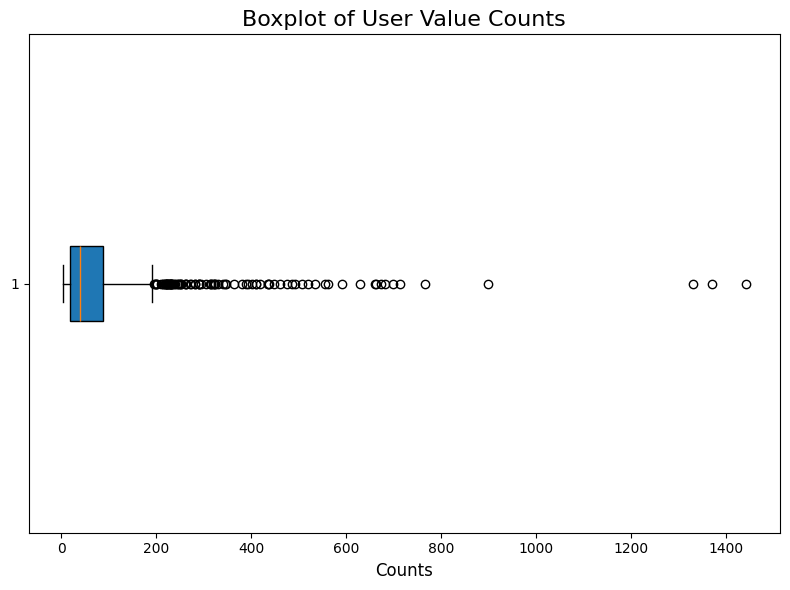

POI
4980
POI_id
42911d00f964a520f5231fe3    643
42829c80f964a5206a221fe3    519
4a737bf8f964a52091dc1fe3    351
4840fe6bf964a52030501fe3    339
40b68100f964a5207d001fe3    302
4a4821f5f964a52095aa1fe3    299
4a513b17f964a520d2b01fe3    277
49b7ed6df964a52030531fe3    264
43a52546f964a520532c1fe3    243
3fd66200f964a520def11ee3    224
Name: count, dtype: int64
count    4980.00000
mean       16.71245
std        23.69805
min         1.00000
25%         6.00000
50%        10.00000
75%        19.00000
max       643.00000
Name: count, dtype: float64


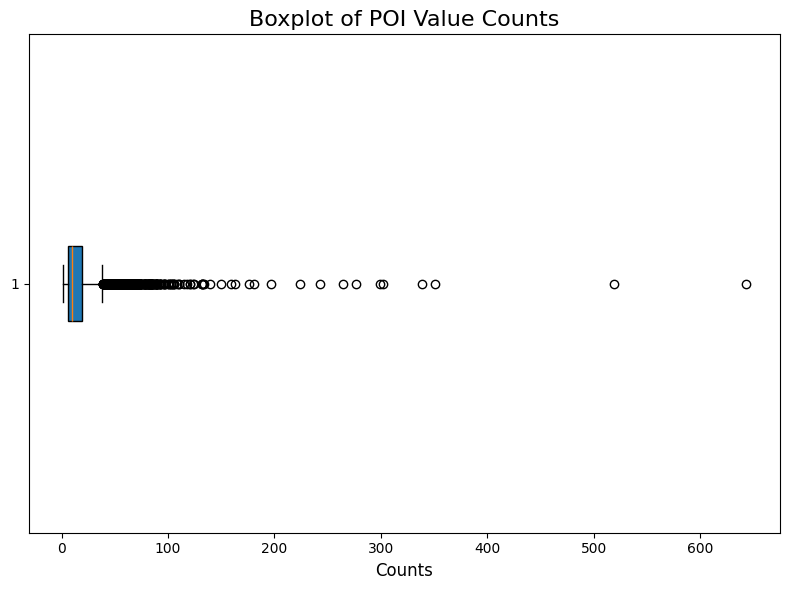

In [11]:
# 박스 플롯 그리기
def visual_box(df, name):
    plt.figure(figsize=(8, 6))
    plt.boxplot(df, vert=False, patch_artist=True)

    # 그래프 스타일 설정
    plt.title(f"Boxplot of {name} Value Counts", fontsize=16)
    plt.xlabel("Counts", fontsize=12)
    plt.tight_layout()

    # 그래프 표시
    plt.show()


# 사용자 정보 저장
user_ids = gdf['user_id'].unique()
n_user = len(gdf['user_id'].unique())
print('User')
print(n_user)
print(gdf['user_id'].value_counts().head(10))
print(gdf['user_id'].value_counts().describe())
visual_box(gdf['user_id'].value_counts(), 'User')
print("=========================================================")

# POI 정보들 가져오기
POIs = gdf['POI_id'].unique()
n_POI = len(gdf['POI_id'].unique())
print('POI')
print(n_POI)
print(gdf['POI_id'].value_counts().head(10))
print(gdf['POI_id'].value_counts().describe())
visual_box(gdf['POI_id'].value_counts(), 'POI')

In [12]:
gdf.loc[gdf['Upper_Category']=='Other', 'POI_catname'].unique()

array(['Bridge', 'Other Nightlife', 'Building', 'Moving Target', 'River',
       'City'], dtype=object)

# 1. 주중, 주말 데이터 비교

In [13]:
# 휴일 POI 확인
holiday_groups = gdf.loc[gdf['holiday']==True, :]
print(len(holiday_groups))

# 평시 POI 확인
weekday_groups = gdf.loc[gdf['holiday']==False, :]
print(len(weekday_groups))

20674
62554


In [14]:
# 시각화
holiday_layer = Layer(holiday_groups, 
                      color_category_style('Upper_Category', size=3, palette='Prism'))

weekday_layer = Layer(weekday_groups, 
                      color_category_style('Upper_Category', size=3, palette='Prism'))

In [15]:
# holiday_layer

In [16]:
#weekday_layer

In [17]:
# 상위 카테고리 시각화
def visual_cat_pie(df, day):

    # 데이터 준비
    labels = df.index
    sizes = df.values
    
    # 시각화
    plt.figure(figsize=(8, 8))
    wedges, texts, autotexts = plt.pie(
        sizes,
        #labels=labels,
        autopct=lambda pct: ('%.1f%%' % pct) if pct > 2 else '',  # 5% 미만 비율은 표시하지 않음
        startangle=90,      # 시작 각도
        # labeldistance=1.1,    # 라벨 위치 (중심에서 떨어진 거리)
        pctdistance=0.85,   # 퍼센트 위치 (중심에서 떨어진 거리)
    )
    
    # 범례 추가
    plt.legend(
        wedges, labels, 
        title="Categories", 
        loc="upper left", 
        bbox_to_anchor=(0.9, 1),  # 범례 위치 설정
        fontsize=10
    )

    # 그래프 스타일 설정
    plt.title(f"{day} Upper_Category Distribution", fontsize=16)
    plt.tight_layout()

    # 그래프 표시
    plt.show()

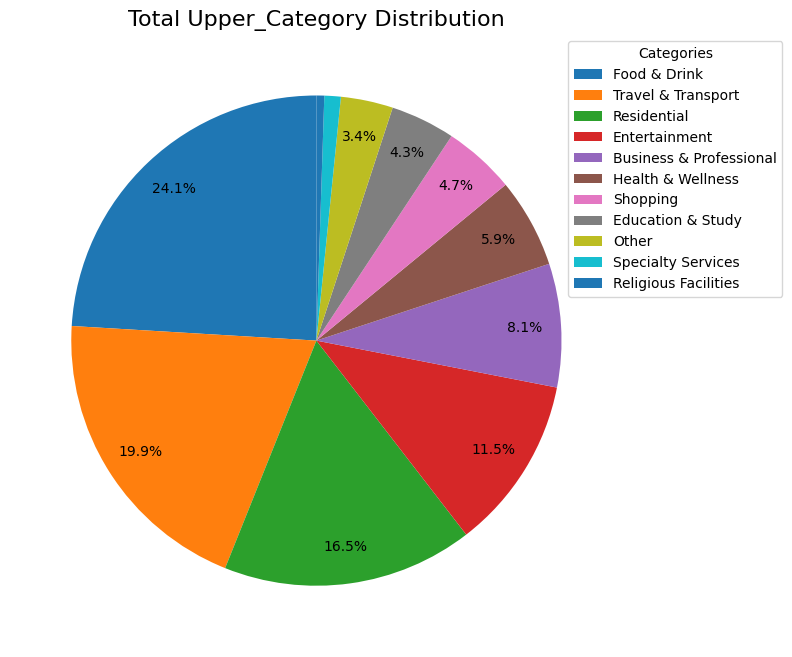

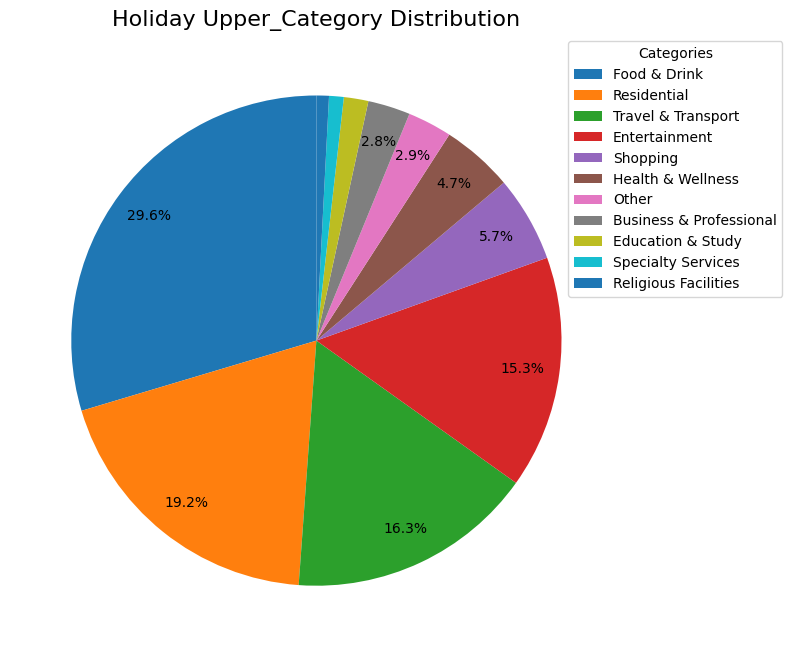

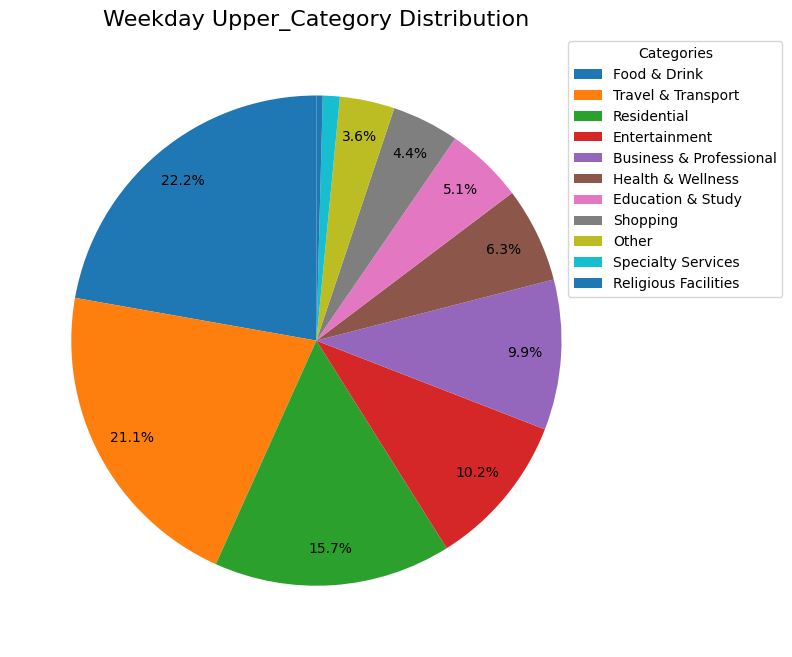

In [18]:
# 휴일별 많은 카테고리
total_cat = gdf['Upper_Category'].value_counts()
holiday_cat = holiday_groups['Upper_Category'].value_counts()
weekday_cat = weekday_groups['Upper_Category'].value_counts()

visual_cat_pie(total_cat, 'Total')
visual_cat_pie(holiday_cat, 'Holiday')
visual_cat_pie(weekday_cat, 'Weekday')

# 2. 카테고리별 방문 시간대 확인

In [19]:
def spatiotemporal_analysis(df):
    df['hour'] = pd.to_datetime(df['local_time']).dt.hour
    df['minute'] = df['local_time'].dt.minute
    top_categories = df['Upper_Category'].value_counts().index
    filtered_df = df[df['Upper_Category'].isin(top_categories)]
    popular_poi_by_hour = filtered_df.groupby(['Upper_Category', 'hour']).size().unstack(fill_value=0)
    plt.figure(figsize=(12, 8))
    sns.heatmap(popular_poi_by_hour, cmap="YlGnBu", cbar=True)
    plt.title("Popular POI Category by Hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("POI Category")
    plt.show()

In [20]:
def most_visited_categories(df):
    category_counts = df['POI_catname'].value_counts().head(30)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=category_counts.values, y=category_counts.index)
    plt.title("Most Visited Categories")
    plt.xlabel("Visit Counts")
    plt.ylabel("Categories")
    plt.show()

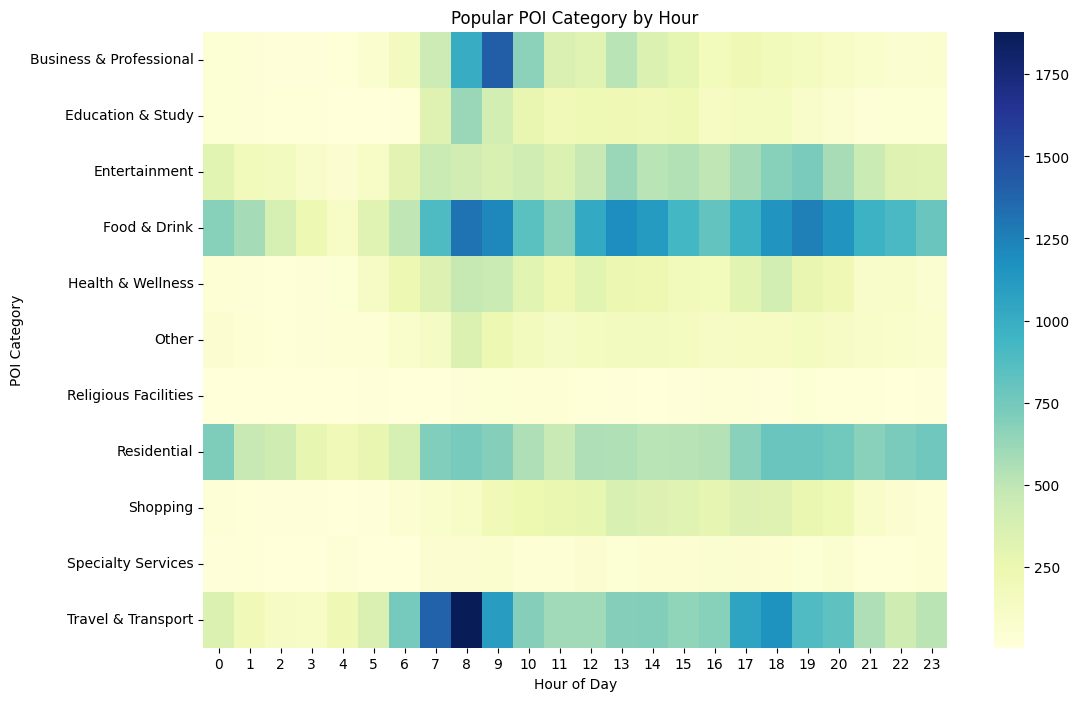

In [21]:
# 상위 카테고리 별 방문 시간 확인
spatiotemporal_analysis(gdf)

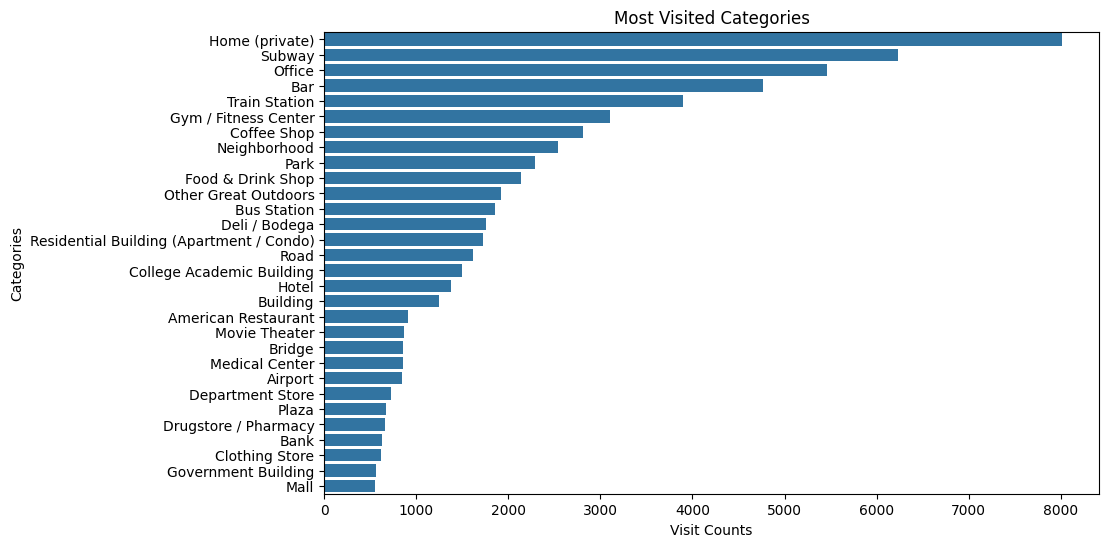

In [22]:
most_visited_categories(gdf)

In [40]:
Home_layer = Layer(gdf.loc[gdf['Upper_Category']=='Residential'])
Home_layer

In [24]:
Layer(gdf.loc[gdf['POI_catname']=='Home (private)'])

In [25]:
len(gdf.loc[gdf['Upper_Category']=='Residential', 'POI_id'].unique())

635

# 3. 사용자별 경로 확인

In [26]:
user_ids

array([470, 979,  69, ..., 587, 687, 796], shape=(1047,))

In [27]:
# 사용자 일별 경로 그룹핑
gdf["date"] = gdf["local_time"].dt.date
trajectory = gdf.groupby(["user_id", "date"])

In [28]:
# 원하는 사용자 경로 확인
def get_user_trajectory(user, start_date, end_date):
    filtered = gdf[(gdf["user_id"] == user) & (gdf["date"] >= start_date) & (gdf["date"] <= end_date)]
    grouped = filtered.groupby('date')
    
    filtered["date"] = filtered["date"].astype(str)
    # Layer 저장
    layer = Layer(filtered, 
                  color_category_style('POI_catname', size=5, palette='Peach')
                  )
    

    for date, group in grouped:
        print(f"Date: {date}")
        df = group[['user_id', 'POI_id', 'POI_catname', 'day_of_week', 'holiday', 'Upper_Category', 'geometry', 'hour', 'minute', 'date']]#,'local_time', 'trajectory_id', 'POI_catid'
        display(df)
        print("-" * 100)
    
    return layer

In [29]:
# 원하는 사용자 경로 확인
def get_user_daily_trajectory(user, date):
    filtered = gdf[(gdf["user_id"] == user) & (gdf["date"] == date)]
    
    filtered["date"] = filtered["date"].astype(str)
    # Layer 저장
    layer = Layer(filtered, 
                  color_category_style('POI_catname', size=5, palette='Peach')
                  )
    return layer

In [30]:
# 날짜 범위를 설정
start_date = pd.Timestamp("2012-06-01").date()
end_date = pd.Timestamp("2012-06-07").date()

In [31]:
gdf.loc[(gdf['user_id']==471), :]

,user_id,POI_id,POI_catid,POI_catid_code,POI_catname,latitude,longitude,timezone,UTC_time,local_time,...,norm_in_day_time,trajectory_id,norm_day_shift,norm_relative_time,holiday,Upper_Category,geometry,hour,minute,date
4109,471,4a928e9df964a520281d20e3,4bf58dd8d48988d176941735,157,Gym / Fitness Center,40.753651,-73.969484,-240,2012-04-10 23:19:05+00:00,2012-04-10 19:19:05+00:00,...,0.791667,471_4,0,0.791667,False,Health & Wellness,POINT (-73.96948 40.75365),19,19,2012-04-10
4718,471,4f53022de4b02d0eb4152d42,4f2a25ac4b909258e854f55f,369,Neighborhood,40.753247,-73.974736,-240,2012-04-11 17:16:50+00:00,2012-04-11 13:16:50+00:00,...,0.541667,471_4,1,1.541667,False,Residential,POINT (-73.97474 40.75325),13,16,2012-04-11
5090,471,4a928e9df964a520281d20e3,4bf58dd8d48988d176941735,157,Gym / Fitness Center,40.753651,-73.969484,-240,2012-04-12 00:11:13+00:00,2012-04-11 20:11:13+00:00,...,0.833333,471_4,1,1.833333,False,Health & Wellness,POINT (-73.96948 40.75365),20,11,2012-04-11
5709,471,4f53022de4b02d0eb4152d42,4f2a25ac4b909258e854f55f,369,Neighborhood,40.753247,-73.974736,-240,2012-04-12 13:52:51+00:00,2012-04-12 09:52:51+00:00,...,0.395833,471_4,2,2.395833,False,Residential,POINT (-73.97474 40.75325),9,52,2012-04-12
5710,471,4ca4e519a6e08cfa884d6c94,4f2a25ac4b909258e854f55f,369,Neighborhood,40.762032,-73.985152,-240,2012-04-12 13:52:59+00:00,2012-04-12 09:52:59+00:00,...,0.395833,471_4,2,2.395833,False,Residential,POINT (-73.98515 40.76203),9,52,2012-04-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69533,471,4f8c5995e4b00597a0fd48fe,4bf58dd8d48988d162941735,138,Other Great Outdoors,40.746737,-73.982620,-240,2012-07-18 16:39:09+00:00,2012-07-18 12:39:09+00:00,...,0.520833,471_37,1,1.520833,False,Entertainment,POINT (-73.98262 40.74674),12,39,2012-07-18
69539,471,4b82c757f964a5205de430e3,4bf58dd8d48988d1d1941735,239,Ramen / Noodle House,40.754391,-73.973077,-240,2012-07-18 16:46:40+00:00,2012-07-18 12:46:40+00:00,...,0.520833,471_37,1,1.520833,False,Food & Drink,POINT (-73.97308 40.75439),12,46,2012-07-18
70101,471,4f53022de4b02d0eb4152d42,4f2a25ac4b909258e854f55f,369,Neighborhood,40.756389,-73.971826,-240,2012-07-24 16:35:03+00:00,2012-07-24 12:35:03+00:00,...,0.520833,471_39,0,0.520833,False,Residential,POINT (-73.97183 40.75639),12,35,2012-07-24
70105,471,4c4dd520f53d0f477f73a3a5,4bf58dd8d48988d124941735,69,Office,40.753941,-73.975080,-240,2012-07-24 16:37:27+00:00,2012-07-24 12:37:27+00:00,...,0.520833,471_39,0,0.520833,False,Business & Professional,POINT (-73.97508 40.75394),12,37,2012-07-24


In [32]:
# 사용자 470
layer_471 = get_user_trajectory(471, start_date, end_date)
layer_471

Date: 2012-06-02


/home/hj/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,user_id,POI_id,POI_catname,day_of_week,holiday,Upper_Category,geometry,hour,minute,date
47966,471,49d7aaf5f964a5204a5d1fe3,Clothing Store,5,True,Shopping,POINT (-73.99981 40.72180),20,32,2012-06-02
47968,471,4555bea7f964a520253d1fe3,Clothing Store,5,True,Shopping,POINT (-73.99813 40.72355),20,36,2012-06-02
48006,471,4a673d8ef964a52007c91fe3,Plaza,5,True,Entertainment,POINT (-73.97156 40.75354),21,37,2012-06-02


----------------------------------------------------------------------------------------------------
Date: 2012-06-03


,user_id,POI_id,POI_catname,day_of_week,holiday,Upper_Category,geometry,hour,minute,date
48610,471,4a673d8ef964a52007c91fe3,Plaza,6,True,Entertainment,POINT (-73.97156 40.75354),19,23,2012-06-03
48611,471,4a928e9df964a520281d20e3,Gym / Fitness Center,6,True,Health & Wellness,POINT (-73.96975 40.75368),19,24,2012-06-03


----------------------------------------------------------------------------------------------------
Date: 2012-06-05


,user_id,POI_id,POI_catname,day_of_week,holiday,Upper_Category,geometry,hour,minute,date
49517,471,4a673d8ef964a52007c91fe3,Plaza,1,False,Entertainment,POINT (-73.97156 40.75354),7,26,2012-06-05
49518,471,4a928e9df964a520281d20e3,Gym / Fitness Center,1,False,Health & Wellness,POINT (-73.96975 40.75368),7,26,2012-06-05
49711,471,4c4dd520f53d0f477f73a3a5,Office,1,False,Business & Professional,POINT (-73.97508 40.75394),9,42,2012-06-05
49723,471,4a8df0c5f964a5207e1120e3,Coffee Shop,1,False,Food & Drink,POINT (-73.97477 40.75299),9,48,2012-06-05


----------------------------------------------------------------------------------------------------
Date: 2012-06-06


,user_id,POI_id,POI_catname,day_of_week,holiday,Upper_Category,geometry,hour,minute,date
50091,471,4c4dd520f53d0f477f73a3a5,Office,2,False,Business & Professional,POINT (-73.97508 40.75394),10,1,2012-06-06
50092,471,4ae5c445f964a520dfa121e3,Café,2,False,Food & Drink,POINT (-73.97441 40.75354),10,2,2012-06-06
50265,471,4b82c757f964a5205de430e3,Ramen / Noodle House,2,False,Food & Drink,POINT (-73.97308 40.75439),13,34,2012-06-06


----------------------------------------------------------------------------------------------------
Date: 2012-06-07


,user_id,POI_id,POI_catname,day_of_week,holiday,Upper_Category,geometry,hour,minute,date
51175,471,4ae5c445f964a520dfa121e3,Café,3,False,Food & Drink,POINT (-73.97441 40.75354),10,26,2012-06-07
51308,471,4b82c757f964a5205de430e3,Ramen / Noodle House,3,False,Food & Drink,POINT (-73.97308 40.75439),13,13,2012-06-07


----------------------------------------------------------------------------------------------------


In [33]:
# 사용자 470
layer_384 = get_user_trajectory(384, start_date, end_date)
layer_384

Date: 2012-06-01


/home/hj/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,user_id,POI_id,POI_catname,day_of_week,holiday,Upper_Category,geometry,hour,minute,date
47475,384,4b8d5d69f964a5204af732e3,Deli / Bodega,4,False,Food & Drink,POINT (-73.98389 40.74379),8,4,2012-06-01
47476,384,4c4798891ddec92873069e32,Deli / Bodega,4,False,Food & Drink,POINT (-73.98239 40.74446),8,4,2012-06-01
47477,384,4a679cbef964a520c9c91fe3,Building,4,False,Other,POINT (-73.98246 40.74435),8,4,2012-06-01
47478,384,4bfd63edf7c82d7f831d8e04,Hotel,4,False,Residential,POINT (-73.98400 40.74394),8,5,2012-06-01
47479,384,4ce390f31594236aa607f849,Home (private),4,False,Residential,POINT (-73.97713 40.73944),8,5,2012-06-01
47656,384,4b5a2177f964a52027af28e3,Bank,4,False,Business & Professional,POINT (-73.98259 40.74506),10,41,2012-06-01
47657,384,3fd66200f964a5204fe71ee3,French Restaurant,4,False,Food & Drink,POINT (-73.98389 40.74364),10,41,2012-06-01
47658,384,4b06db2df964a5208df122e3,Bank,4,False,Business & Professional,POINT (-73.98221 40.74563),10,41,2012-06-01


----------------------------------------------------------------------------------------------------


In [34]:
layer_293 = get_user_trajectory(293, start_date, end_date)
layer_293

Date: 2012-06-01


/home/hj/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,user_id,POI_id,POI_catname,day_of_week,holiday,Upper_Category,geometry,hour,minute,date
47684,293,4d4b5ceb8e948cfa35fcef48,Home (private),4,False,Residential,POINT (-73.93010 40.69321),12,38,2012-06-01
47685,293,4d2b7e7ab818a35df652b08a,Home (private),4,False,Residential,POINT (-73.93010 40.69321),12,39,2012-06-01
47693,293,4b0b68cef964a5202f3123e3,Subway,4,False,Travel & Transport,POINT (-73.93028 40.67934),12,55,2012-06-01
47725,293,4db12e95a86e63d21166092b,Road,4,False,Travel & Transport,POINT (-74.00399 40.72585),13,41,2012-06-01
47726,293,4aa57787f964a5207c4820e3,Park,4,False,Entertainment,POINT (-74.00347 40.72679),13,42,2012-06-01
47727,293,4b5764b8f964a5207a3528e3,Paper / Office Supplies Store,4,False,Shopping,POINT (-74.00528 40.72702),13,42,2012-06-01
47731,293,49ba7840f964a52067531fe3,General Entertainment,4,False,Entertainment,POINT (-74.00549 40.72693),13,47,2012-06-01
47733,293,4fa2c66ae4b0dc1d01359ad5,Office,4,False,Business & Professional,POINT (-74.00509 40.72649),13,51,2012-06-01


----------------------------------------------------------------------------------------------------
Date: 2012-06-02


,user_id,POI_id,POI_catname,day_of_week,holiday,Upper_Category,geometry,hour,minute,date
47916,293,4e5577f445dd0a4826e6ab3e,Home (private),5,True,Residential,POINT (-73.93010 40.69321),19,38,2012-06-02
47917,293,4d2f5ae2940137044fa1eeda,General Travel,5,True,Travel & Transport,POINT (-73.92964 40.68898),19,39,2012-06-02
47937,293,4d44de972e326ea872f8e8a6,Deli / Bodega,5,True,Food & Drink,POINT (-73.94810 40.70427),20,2,2012-06-02
47938,293,4e8bac9b6c25fbeecd5147f8,General Travel,5,True,Travel & Transport,POINT (-73.94808 40.70409),20,3,2012-06-02
47943,293,4d5bedbb5d153704613a6ce7,Other Great Outdoors,5,True,Entertainment,POINT (-73.94941 40.71409),20,5,2012-06-02
47944,293,4c97edbdf419a09395806b88,Neighborhood,5,True,Residential,POINT (-73.94958 40.65017),20,7,2012-06-02
47945,293,4d61b919865a224bef72ba85,Smoke Shop,5,True,Specialty Services,POINT (-73.94960 40.71595),20,7,2012-06-02


----------------------------------------------------------------------------------------------------
Date: 2012-06-03


,user_id,POI_id,POI_catname,day_of_week,holiday,Upper_Category,geometry,hour,minute,date
48147,293,4bb64e08ef159c74fcbd75f7,Deli / Bodega,6,True,Food & Drink,POINT (-73.94974 40.71607),1,38,2012-06-03
48363,293,4d4b5ceb8e948cfa35fcef48,Home (private),6,True,Residential,POINT (-73.93010 40.69321),12,14,2012-06-03
48365,293,4d2b7e7ab818a35df652b08a,Home (private),6,True,Residential,POINT (-73.93010 40.69321),12,15,2012-06-03
48372,293,4e5577f445dd0a4826e6ab3e,Home (private),6,True,Residential,POINT (-73.93010 40.69321),12,22,2012-06-03
48374,293,4d2f5ae2940137044fa1eeda,General Travel,6,True,Travel & Transport,POINT (-73.92964 40.68898),12,24,2012-06-03
48395,293,4e8bac9b6c25fbeecd5147f8,General Travel,6,True,Travel & Transport,POINT (-73.94808 40.70409),12,57,2012-06-03
48401,293,4d5bedbb5d153704613a6ce7,Other Great Outdoors,6,True,Entertainment,POINT (-73.94941 40.71409),13,4,2012-06-03
48403,293,4c97edbdf419a09395806b88,Neighborhood,6,True,Residential,POINT (-73.94958 40.65017),13,5,2012-06-03
48404,293,4d61b919865a224bef72ba85,Smoke Shop,6,True,Specialty Services,POINT (-73.94960 40.71595),13,6,2012-06-03
48679,293,429ba900f964a52093241fe3,Bakery,6,True,Food & Drink,POINT (-73.94950 40.71506),21,17,2012-06-03


----------------------------------------------------------------------------------------------------
Date: 2012-06-04


,user_id,POI_id,POI_catname,day_of_week,holiday,Upper_Category,geometry,hour,minute,date
49222,293,4fa2c66ae4b0dc1d01359ad5,Office,0,False,Business & Professional,POINT (-74.00509 40.72649),19,32,2012-06-04
49248,293,4db12e95a86e63d21166092b,Road,0,False,Travel & Transport,POINT (-74.00399 40.72585),19,54,2012-06-04
49250,293,4ae8fd76f964a520e1b321e3,Subway,0,False,Travel & Transport,POINT (-74.00425 40.72558),19,55,2012-06-04
49262,293,4d5bedbb5d153704613a6ce7,Other Great Outdoors,0,False,Entertainment,POINT (-73.94941 40.71409),20,19,2012-06-04
49263,293,4c97edbdf419a09395806b88,Neighborhood,0,False,Residential,POINT (-73.94958 40.65017),20,20,2012-06-04


----------------------------------------------------------------------------------------------------
Date: 2012-06-05


,user_id,POI_id,POI_catname,day_of_week,holiday,Upper_Category,geometry,hour,minute,date
49391,293,4c97edbdf419a09395806b88,Neighborhood,1,False,Residential,POINT (-73.94958 40.65017),0,22,2012-06-05
49392,293,4d5bedbb5d153704613a6ce7,Other Great Outdoors,1,False,Entertainment,POINT (-73.94941 40.71409),0,22,2012-06-05
49401,293,4e6eab51d1647b1137a3a2d0,Bus Station,1,False,Travel & Transport,POINT (-73.94822 40.70403),0,41,2012-06-05


----------------------------------------------------------------------------------------------------
Date: 2012-06-06


,user_id,POI_id,POI_catname,day_of_week,holiday,Upper_Category,geometry,hour,minute,date
50200,293,4d4b5ceb8e948cfa35fcef48,Home (private),2,False,Residential,POINT (-73.93010 40.69321),12,28,2012-06-06
50202,293,4d2b7e7ab818a35df652b08a,Home (private),2,False,Residential,POINT (-73.93010 40.69321),12,29,2012-06-06
50210,293,4d2f5ae2940137044fa1eeda,General Travel,2,False,Travel & Transport,POINT (-73.92964 40.68898),12,38,2012-06-06
50244,293,4ae8fd76f964a520e1b321e3,Subway,2,False,Travel & Transport,POINT (-74.00425 40.72558),13,15,2012-06-06
50245,293,4db12e95a86e63d21166092b,Road,2,False,Travel & Transport,POINT (-74.00399 40.72585),13,15,2012-06-06
50247,293,4aa57787f964a5207c4820e3,Park,2,False,Entertainment,POINT (-74.00347 40.72679),13,16,2012-06-06
50418,293,49ba7840f964a52067531fe3,General Entertainment,2,False,Entertainment,POINT (-74.00549 40.72693),17,15,2012-06-06
50421,293,4fa2c66ae4b0dc1d01359ad5,Office,2,False,Business & Professional,POINT (-74.00509 40.72649),17,22,2012-06-06
50594,293,4db12e95a86e63d21166092b,Road,2,False,Travel & Transport,POINT (-74.00399 40.72585),19,53,2012-06-06
50595,293,4ae8fd76f964a520e1b321e3,Subway,2,False,Travel & Transport,POINT (-74.00425 40.72558),19,54,2012-06-06


----------------------------------------------------------------------------------------------------
Date: 2012-06-07


,user_id,POI_id,POI_catname,day_of_week,holiday,Upper_Category,geometry,hour,minute,date
50795,293,4d5bedbb5d153704613a6ce7,Other Great Outdoors,3,False,Entertainment,POINT (-73.94941 40.71409),1,7,2012-06-07
50799,293,4c97edbdf419a09395806b88,Neighborhood,3,False,Residential,POINT (-73.94958 40.65017),1,7,2012-06-07
50809,293,4e6eab51d1647b1137a3a2d0,Bus Station,3,False,Travel & Transport,POINT (-73.94822 40.70403),1,34,2012-06-07
51233,293,4d4b5ceb8e948cfa35fcef48,Home (private),3,False,Residential,POINT (-73.93010 40.69321),12,1,2012-06-07
51234,293,4d2b7e7ab818a35df652b08a,Home (private),3,False,Residential,POINT (-73.93010 40.69321),12,2,2012-06-07
51244,293,4d2f5ae2940137044fa1eeda,General Travel,3,False,Travel & Transport,POINT (-73.92964 40.68898),12,11,2012-06-07
51245,293,4b0b68cef964a5202f3123e3,Subway,3,False,Travel & Transport,POINT (-73.93028 40.67934),12,11,2012-06-07
51258,293,4b0b68cef964a5202f3123e3,Subway,3,False,Travel & Transport,POINT (-73.93028 40.67934),12,23,2012-06-07
51301,293,4ae8fd76f964a520e1b321e3,Subway,3,False,Travel & Transport,POINT (-74.00425 40.72558),13,7,2012-06-07
51302,293,4db12e95a86e63d21166092b,Road,3,False,Travel & Transport,POINT (-74.00399 40.72585),13,8,2012-06-07


----------------------------------------------------------------------------------------------------


In [35]:
Layer(gdf[gdf['POI_catname']=='Neighborhood'])

In [36]:
display(gdf[(gdf["user_id"] == 293) & (gdf["date"] == pd.Timestamp("2012-06-03").date())])
# 하루내 이동 확인
get_user_daily_trajectory(293, pd.Timestamp("2012-06-03").date())

,user_id,POI_id,POI_catid,POI_catid_code,POI_catname,latitude,longitude,timezone,UTC_time,local_time,...,norm_in_day_time,trajectory_id,norm_day_shift,norm_relative_time,holiday,Upper_Category,geometry,hour,minute,date
48147,293,4bb64e08ef159c74fcbd75f7,4bf58dd8d48988d146941735,110,Deli / Bodega,40.716069,-73.949739,-240,2012-06-03 05:38:06+00:00,2012-06-03 01:38:06+00:00,...,0.062500,293_11,1,1.062500,True,Food & Drink,POINT (-73.94974 40.71607),1,38,2012-06-03
48363,293,4d4b5ceb8e948cfa35fcef48,4bf58dd8d48988d103941735,6,Home (private),40.693212,-73.930104,-240,2012-06-03 16:14:50+00:00,2012-06-03 12:14:50+00:00,...,0.500000,293_11,1,1.500000,True,Residential,POINT (-73.93010 40.69321),12,14,2012-06-03
48365,293,4d2b7e7ab818a35df652b08a,4bf58dd8d48988d103941735,6,Home (private),40.693212,-73.930104,-240,2012-06-03 16:15:42+00:00,2012-06-03 12:15:42+00:00,...,0.500000,293_11,1,1.500000,True,Residential,POINT (-73.93010 40.69321),12,15,2012-06-03
48372,293,4e5577f445dd0a4826e6ab3e,4bf58dd8d48988d103941735,6,Home (private),40.693212,-73.930104,-240,2012-06-03 16:22:35+00:00,2012-06-03 12:22:35+00:00,...,0.500000,293_11,1,1.500000,True,Residential,POINT (-73.93010 40.69321),12,22,2012-06-03
48374,293,4d2f5ae2940137044fa1eeda,4bf58dd8d48988d1f6931735,293,General Travel,40.688982,-73.929642,-240,2012-06-03 16:24:27+00:00,2012-06-03 12:24:27+00:00,...,0.500000,293_11,1,1.500000,True,Travel & Transport,POINT (-73.92964 40.68898),12,24,2012-06-03
48395,293,4e8bac9b6c25fbeecd5147f8,4bf58dd8d48988d1f6931735,293,General Travel,40.704086,-73.948080,-240,2012-06-03 16:57:22+00:00,2012-06-03 12:57:22+00:00,...,0.520833,293_11,1,1.520833,True,Travel & Transport,POINT (-73.94808 40.70409),12,57,2012-06-03
48401,293,4d5bedbb5d153704613a6ce7,4bf58dd8d48988d162941735,138,Other Great Outdoors,40.714088,-73.949406,-240,2012-06-03 17:04:24+00:00,2012-06-03 13:04:24+00:00,...,0.541667,293_11,1,1.541667,True,Entertainment,POINT (-73.94941 40.71409),13,4,2012-06-03
48403,293,4c97edbdf419a09395806b88,4f2a25ac4b909258e854f55f,369,Neighborhood,40.650169,-73.949575,-240,2012-06-03 17:05:47+00:00,2012-06-03 13:05:47+00:00,...,0.541667,293_11,1,1.541667,True,Residential,POINT (-73.94958 40.65017),13,5,2012-06-03
48404,293,4d61b919865a224bef72ba85,4bf58dd8d48988d123951735,68,Smoke Shop,40.715951,-73.949595,-240,2012-06-03 17:06:22+00:00,2012-06-03 13:06:22+00:00,...,0.541667,293_11,1,1.541667,True,Specialty Services,POINT (-73.94960 40.71595),13,6,2012-06-03
48679,293,429ba900f964a52093241fe3,4bf58dd8d48988d16a941735,146,Bakery,40.715056,-73.949503,-240,2012-06-04 01:17:56+00:00,2012-06-03 21:17:56+00:00,...,0.875000,293_11,1,1.875000,True,Food & Drink,POINT (-73.94950 40.71506),21,17,2012-06-03


/home/hj/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [37]:
display(gdf[(gdf["user_id"] == 293) & (gdf["date"] == pd.Timestamp("2012-06-03").date())])
# 하루내 이동 확인
get_user_daily_trajectory(293, pd.Timestamp("2012-06-03").date())

,user_id,POI_id,POI_catid,POI_catid_code,POI_catname,latitude,longitude,timezone,UTC_time,local_time,...,norm_in_day_time,trajectory_id,norm_day_shift,norm_relative_time,holiday,Upper_Category,geometry,hour,minute,date
48147,293,4bb64e08ef159c74fcbd75f7,4bf58dd8d48988d146941735,110,Deli / Bodega,40.716069,-73.949739,-240,2012-06-03 05:38:06+00:00,2012-06-03 01:38:06+00:00,...,0.062500,293_11,1,1.062500,True,Food & Drink,POINT (-73.94974 40.71607),1,38,2012-06-03
48363,293,4d4b5ceb8e948cfa35fcef48,4bf58dd8d48988d103941735,6,Home (private),40.693212,-73.930104,-240,2012-06-03 16:14:50+00:00,2012-06-03 12:14:50+00:00,...,0.500000,293_11,1,1.500000,True,Residential,POINT (-73.93010 40.69321),12,14,2012-06-03
48365,293,4d2b7e7ab818a35df652b08a,4bf58dd8d48988d103941735,6,Home (private),40.693212,-73.930104,-240,2012-06-03 16:15:42+00:00,2012-06-03 12:15:42+00:00,...,0.500000,293_11,1,1.500000,True,Residential,POINT (-73.93010 40.69321),12,15,2012-06-03
48372,293,4e5577f445dd0a4826e6ab3e,4bf58dd8d48988d103941735,6,Home (private),40.693212,-73.930104,-240,2012-06-03 16:22:35+00:00,2012-06-03 12:22:35+00:00,...,0.500000,293_11,1,1.500000,True,Residential,POINT (-73.93010 40.69321),12,22,2012-06-03
48374,293,4d2f5ae2940137044fa1eeda,4bf58dd8d48988d1f6931735,293,General Travel,40.688982,-73.929642,-240,2012-06-03 16:24:27+00:00,2012-06-03 12:24:27+00:00,...,0.500000,293_11,1,1.500000,True,Travel & Transport,POINT (-73.92964 40.68898),12,24,2012-06-03
48395,293,4e8bac9b6c25fbeecd5147f8,4bf58dd8d48988d1f6931735,293,General Travel,40.704086,-73.948080,-240,2012-06-03 16:57:22+00:00,2012-06-03 12:57:22+00:00,...,0.520833,293_11,1,1.520833,True,Travel & Transport,POINT (-73.94808 40.70409),12,57,2012-06-03
48401,293,4d5bedbb5d153704613a6ce7,4bf58dd8d48988d162941735,138,Other Great Outdoors,40.714088,-73.949406,-240,2012-06-03 17:04:24+00:00,2012-06-03 13:04:24+00:00,...,0.541667,293_11,1,1.541667,True,Entertainment,POINT (-73.94941 40.71409),13,4,2012-06-03
48403,293,4c97edbdf419a09395806b88,4f2a25ac4b909258e854f55f,369,Neighborhood,40.650169,-73.949575,-240,2012-06-03 17:05:47+00:00,2012-06-03 13:05:47+00:00,...,0.541667,293_11,1,1.541667,True,Residential,POINT (-73.94958 40.65017),13,5,2012-06-03
48404,293,4d61b919865a224bef72ba85,4bf58dd8d48988d123951735,68,Smoke Shop,40.715951,-73.949595,-240,2012-06-03 17:06:22+00:00,2012-06-03 13:06:22+00:00,...,0.541667,293_11,1,1.541667,True,Specialty Services,POINT (-73.94960 40.71595),13,6,2012-06-03
48679,293,429ba900f964a52093241fe3,4bf58dd8d48988d16a941735,146,Bakery,40.715056,-73.949503,-240,2012-06-04 01:17:56+00:00,2012-06-03 21:17:56+00:00,...,0.875000,293_11,1,1.875000,True,Food & Drink,POINT (-73.94950 40.71506),21,17,2012-06-03


/home/hj/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [38]:
gdf.loc[(gdf['user_id']==293) & (gdf["date"]==pd.Timestamp("2012-04-13").date())]

,user_id,POI_id,POI_catid,POI_catid_code,POI_catname,latitude,longitude,timezone,UTC_time,local_time,...,norm_in_day_time,trajectory_id,norm_day_shift,norm_relative_time,holiday,Upper_Category,geometry,hour,minute,date
6395,293,4c97edbdf419a09395806b88,4f2a25ac4b909258e854f55f,369,Neighborhood,40.650169,-73.949575,-240,2012-04-13 06:04:17+00:00,2012-04-13 02:04:17+00:00,...,0.083333,293_2,7,7.083333,False,Residential,POINT (-73.94958 40.65017),2,4,2012-04-13
6396,293,4d5bedbb5d153704613a6ce7,4bf58dd8d48988d162941735,138,Other Great Outdoors,40.714310,-73.949394,-240,2012-04-13 06:05:19+00:00,2012-04-13 02:05:19+00:00,...,0.083333,293_2,7,7.083333,False,Entertainment,POINT (-73.94939 40.71431),2,5,2012-04-13
6401,293,4e6eab51d1647b1137a3a2d0,4bf58dd8d48988d12b951735,83,Bus Station,40.704168,-73.948189,-240,2012-04-13 06:33:16+00:00,2012-04-13 02:33:16+00:00,...,0.104167,293_2,7,7.104167,False,Travel & Transport,POINT (-73.94819 40.70417),2,33,2012-04-13
6837,293,4d4b5ceb8e948cfa35fcef48,4bf58dd8d48988d103941735,6,Home (private),40.693212,-73.930104,-240,2012-04-13 15:58:34+00:00,2012-04-13 11:58:34+00:00,...,0.479167,293_2,7,7.479167,False,Residential,POINT (-73.93010 40.69321),11,58,2012-04-13
6838,293,4d2b7e7ab818a35df652b08a,4bf58dd8d48988d103941735,6,Home (private),40.693212,-73.930104,-240,2012-04-13 15:58:47+00:00,2012-04-13 11:58:47+00:00,...,0.479167,293_2,7,7.479167,False,Residential,POINT (-73.93010 40.69321),11,58,2012-04-13
6854,293,4e5577f445dd0a4826e6ab3e,4bf58dd8d48988d103941735,6,Home (private),40.693212,-73.930104,-240,2012-04-13 16:18:13+00:00,2012-04-13 12:18:13+00:00,...,0.500000,293_2,7,7.500000,False,Residential,POINT (-73.93010 40.69321),12,18,2012-04-13
6856,293,4d2f5ae2940137044fa1eeda,4bf58dd8d48988d1f6931735,293,General Travel,40.689003,-73.929085,-240,2012-04-13 16:18:55+00:00,2012-04-13 12:18:55+00:00,...,0.500000,293_2,7,7.500000,False,Travel & Transport,POINT (-73.92908 40.68900),12,18,2012-04-13
6858,293,4b0b68cef964a5202f3123e3,4bf58dd8d48988d1fd931735,307,Subway,40.679336,-73.930285,-240,2012-04-13 16:20:17+00:00,2012-04-13 12:20:17+00:00,...,0.500000,293_2,7,7.500000,False,Travel & Transport,POINT (-73.93028 40.67934),12,20,2012-04-13
7307,293,4ae8fd76f964a520e1b321e3,4bf58dd8d48988d1fd931735,307,Subway,40.725577,-74.004252,-240,2012-04-13 23:51:20+00:00,2012-04-13 19:51:20+00:00,...,0.812500,293_2,7,7.812500,False,Travel & Transport,POINT (-74.00425 40.72558),19,51,2012-04-13
7364,293,4e5577f445dd0a4826e6ab3e,4bf58dd8d48988d103941735,6,Home (private),40.693212,-73.930104,-240,2012-04-14 00:51:22+00:00,2012-04-13 20:51:22+00:00,...,0.854167,293_2,7,7.854167,False,Residential,POINT (-73.93010 40.69321),20,51,2012-04-13


In [39]:
# user 기준 그룹핑
users = gdf.groupby("user_id")
users.get_group(470).head(30)


# POI 기준 그룹핑

,user_id,POI_id,POI_catid,POI_catid_code,POI_catname,latitude,longitude,timezone,UTC_time,local_time,...,norm_in_day_time,trajectory_id,norm_day_shift,norm_relative_time,holiday,Upper_Category,geometry,hour,minute,date
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,75,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-03 18:00:09+00:00,2012-04-03 14:00:09+00:00,...,0.583333,470_1,0,0.583333,False,Entertainment,POINT (-74.00258 40.71981),14,0,2012-04-03
318,470,3fd66200f964a5200ae91ee3,4bf58dd8d48988d1e4931735,261,Bowling Alley,40.757394,-73.993301,-240,2012-04-04 00:19:37+00:00,2012-04-03 20:19:37+00:00,...,0.833333,470_1,0,0.833333,False,Entertainment,POINT (-73.99330 40.75739),20,19,2012-04-03
937,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,75,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-04 18:00:09+00:00,2012-04-04 14:00:09+00:00,...,0.583333,470_1,1,1.583333,False,Entertainment,POINT (-74.00258 40.71981),14,0,2012-04-04
2000,470,4ad9f3b3f964a520431c21e3,4bf58dd8d48988d12f941735,89,Library,40.774338,-73.984785,-240,2012-04-08 03:27:40+00:00,2012-04-07 23:27:40+00:00,...,0.958333,470_2,0,0.958333,True,Education & Study,POINT (-73.98478 40.77434),23,27,2012-04-07
2002,470,4b464af8f964a520c01c26e3,4bf58dd8d48988d12f941735,89,Library,40.773229,-73.984616,-240,2012-04-08 03:28:09+00:00,2012-04-07 23:28:09+00:00,...,0.958333,470_2,0,0.958333,True,Education & Study,POINT (-73.98462 40.77323),23,28,2012-04-07
2129,470,3fd66200f964a5205dea1ee3,4bf58dd8d48988d1d3941735,241,Vegetarian / Vegan Restaurant,40.722186,-73.997124,-240,2012-04-08 10:04:22+00:00,2012-04-08 06:04:22+00:00,...,0.250000,470_2,1,1.250000,True,Food & Drink,POINT (-73.99712 40.72219),6,4,2012-04-08
2361,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,75,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-08 18:00:07+00:00,2012-04-08 14:00:07+00:00,...,0.583333,470_2,1,1.583333,True,Entertainment,POINT (-74.00258 40.71981),14,0,2012-04-08
3089,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,75,Arts & Crafts Store,40.719810,-74.002581,-240,2012-04-09 18:01:05+00:00,2012-04-09 14:01:05+00:00,...,0.583333,470_3,0,0.583333,False,Entertainment,POINT (-74.00258 40.71981),14,1,2012-04-09
3661,470,4ad4a7c0f964a52085e820e3,4bf58dd8d48988d1c1941735,224,Mexican Restaurant,40.694157,-73.991873,-240,2012-04-10 07:58:56+00:00,2012-04-10 03:58:56+00:00,...,0.145833,470_3,1,1.145833,False,Food & Drink,POINT (-73.99187 40.69416),3,58,2012-04-10
3662,470,4ec27c885c5c3d470deb0904,4bf58dd8d48988d1c1941735,224,Mexican Restaurant,40.725929,-73.996395,-240,2012-04-10 08:03:26+00:00,2012-04-10 04:03:26+00:00,...,0.166667,470_3,1,1.166667,False,Food & Drink,POINT (-73.99639 40.72593),4,3,2012-04-10
